In [23]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

class ImprovedFairnessAnalysis:
    def __init__(self, datasets_dir='datasets'):
        self.datasets_dir = datasets_dir
        self.datasets = {}
        self.protected_attributes = {
            'adult': ['sex', 'race'],
            'compas': ['sex', 'race'],
            'german': ['sex', 'age']
        }

    def safe_divide(self, numerator, denominator, default=0.0):
        """Safely handle division by zero."""
        return np.divide(
            numerator,
            denominator,
            out=np.full_like(numerator, default, dtype=float),
            where=denominator!=0
        )
        
    def load_datasets(self):
        """Load and preprocess all datasets."""
        # Load Adult dataset
        adult_path = os.path.join(self.datasets_dir, 'adult_processed.csv')
        adult_data = pd.read_csv(adult_path)
        adult_data['sex'] = adult_data['sex'].astype(int)
        adult_data['race'] = adult_data['race'].astype(int)
        adult_data['income'] = adult_data['income'].astype(int)
        self.datasets['adult'] = adult_data
            
        # Load COMPAS dataset
        compas_path = os.path.join(self.datasets_dir, 'compas_processed.csv')
        compas_data = pd.read_csv(compas_path, sep=';')
        compas_processed = pd.DataFrame({
            'sex': (compas_data['gender'] == 'Female').astype(int),
            'race': (compas_data['race'] == 'Caucasian').astype(int),
            'age': compas_data['age'],
            'priors_count': compas_data['priors_count'],
            'two_year_recid': compas_data['two_year_recid'].astype(int)
        })
        self.datasets['compas'] = compas_processed
            
        # Load German Credit dataset
        german_path = os.path.join(self.datasets_dir, 'german_processed_mapped.csv')
        german_data = pd.read_csv(german_path)
        german_data['sex'] = (german_data['Personal_status_and_sex'].isin(['A91', 'A93', 'A94'])).astype(int)
        german_data['age'] = (german_data['Age_in_years'] > 25).astype(int)
        german_data['Risk'] = german_data['Risk'].astype(int)
            
        categorical_columns = [
            'Status_of_existing_checking_account', 'Credit_history', 'Purpose',
            'Savings_account_bonds', 'Present_employment_since', 'Housing',
            'Other_installment_plans', 'Property', 'Other_debtors_guarantors',
            'Job', 'Telephone', 'Foreign_worker'
        ]
        
        for col in categorical_columns:
            german_data[col] = LabelEncoder().fit_transform(german_data[col])
            
        self.datasets['german'] = german_data

        print("All datasets loaded successfully!")
            
    def calculate_fairness_metrics(self, y_true, y_pred, dataset, protected_attrs):
        """Calculate fairness metrics."""
        metrics = {}
        
        for attr in protected_attrs:
            priv_mask = (dataset[attr] == 1)
            unpriv_mask = (dataset[attr] == 0)
            
            # Statistical Parity Difference (SPD)
            priv_pos = np.mean(y_pred[priv_mask]) if np.any(priv_mask) else 0
            unpriv_pos = np.mean(y_pred[unpriv_mask]) if np.any(unpriv_mask) else 0
            metrics[f'{attr}_spd'] = priv_pos - unpriv_pos
            
            # True Positive Rate (TPR)
            priv_tpr = self.safe_divide(
                np.sum((y_pred == 1) & (y_true == 1) & priv_mask),
                np.sum((y_true == 1) & priv_mask)
            )
            unpriv_tpr = self.safe_divide(
                np.sum((y_pred == 1) & (y_true == 1) & unpriv_mask),
                np.sum((y_true == 1) & unpriv_mask)
            )
            
            # False Positive Rate (FPR)
            priv_fpr = self.safe_divide(
                np.sum((y_pred == 1) & (y_true == 0) & priv_mask),
                np.sum((y_true == 0) & priv_mask)
            )
            unpriv_fpr = self.safe_divide(
                np.sum((y_pred == 1) & (y_true == 0) & unpriv_mask),
                np.sum((y_true == 0) & unpriv_mask)
            )
            
            # Equal Opportunity Difference (EOD)
            metrics[f'{attr}_eod'] = priv_tpr - unpriv_tpr
            
            # Average Odds Difference (AOD)
            metrics[f'{attr}_aod'] = 0.5 * ((priv_fpr - unpriv_fpr) + (priv_tpr - unpriv_tpr))
        
        # Worst-case metrics
        metrics['wc_spd'] = max(abs(metrics[f'{attr}_spd']) for attr in protected_attrs)
        metrics['wc_aod'] = max(abs(metrics[f'{attr}_aod']) for attr in protected_attrs)
        metrics['wc_eod'] = max(abs(metrics[f'{attr}_eod']) for attr in protected_attrs)
        
        return metrics
    
    def run_fairhome_experiment(self, dataset_name, classifier_name):
        """Run the FairHOME-like experiment with protected attributes kept binary."""
        dataset = self.datasets[dataset_name]
        protected_attrs = self.protected_attributes[dataset_name]
        
        # Prepare features and labels
        if dataset_name == 'compas':
            y = dataset['two_year_recid']
            X = dataset.drop(['two_year_recid'], axis=1)
        elif dataset_name == 'german':
            y = dataset['Risk']
            X = dataset.drop(['Risk', 'Personal_status_and_sex', 'Age_in_years'], axis=1)
        else:  # adult dataset
            y = dataset['income']
            X = dataset.drop(['income'], axis=1)
        
        # Separate protected and non-protected attributes
        non_protected_attrs = [c for c in X.columns if c not in protected_attrs]
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        
        # Scale only non-protected features
        scaler = StandardScaler()
        X_train_non_prot = scaler.fit_transform(X_train[non_protected_attrs])
        X_test_non_prot = scaler.transform(X_test[non_protected_attrs])
        
        # Reconstruct scaled datasets
        X_train_scaled = X_train.copy()
        X_train_scaled[non_protected_attrs] = X_train_non_prot
        
        X_test_scaled = X_test.copy()
        X_test_scaled[non_protected_attrs] = X_test_non_prot
        
        # Initialize classifier
        if classifier_name == 'rf':
            clf = RandomForestClassifier(n_estimators=100, random_state=42)
        elif classifier_name == 'svm':
            base_svm = LinearSVC(max_iter=2000, random_state=42)
            clf = CalibratedClassifierCV(base_svm)
        else:
            clf = LogisticRegression(max_iter=1000, random_state=42)
        
        # Train classifier
        clf.fit(X_train_scaled, y_train)
        
        # Generate predictions for all combinations of protected attributes
        predictions_list = []
        # Original predictions
        predictions_list.append(clf.predict(X_test_scaled))
        
        # Flip protected attributes
        num_combinations = 2**len(protected_attrs)
        for i in range(1, num_combinations):
            X_modified = X_test_scaled.copy()
            binary = format(i, f'0{len(protected_attrs)}b')
            
            for j, attr in enumerate(protected_attrs):
                # Flip 0->1 or 1->0 directly on the binary attribute
                original_values = X_test[attr].values  # original binary values
                flipped_values = original_values.copy()
                # If we are flipping this attribute, flip the binary values
                if binary[j] == '1':
                    flipped_values = 1 - flipped_values
                # Update the modified dataset with flipped binary values
                X_modified[attr] = flipped_values
            
            predictions_list.append(clf.predict(X_modified))
        
        # Aggregate predictions (majority vote)
        predictions = np.array(predictions_list)
        y_pred = (np.sum(predictions, axis=0) >= (len(predictions) / 2)).astype(int)
        
        # Calculate performance metrics
        performance_metrics = {
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred, average='weighted'),
            'recall': recall_score(y_test, y_pred, average='weighted'),
            'f1': f1_score(y_test, y_pred, average='weighted')
        }
        
        fairness_metrics = self.calculate_fairness_metrics(y_test.values, y_pred, X_test, protected_attrs)
        class_report = classification_report(y_test, y_pred)
        
        return performance_metrics, fairness_metrics, class_report

def run_analysis():
    """Run the complete analysis pipeline."""
    analyzer = ImprovedFairnessAnalysis(datasets_dir='datasets')
    analyzer.load_datasets()
    
    classifiers = ['rf', 'svm', 'lr']
    results = {}
    
    for dataset_name in analyzer.datasets.keys():
        results[dataset_name] = {}
        print(f"\nAnalyzing {dataset_name} dataset:")
        
        for clf_name in classifiers:
            print(f"\nRunning {clf_name} classifier:")
            try:
                perf_metrics, fair_metrics, class_report = analyzer.run_fairhome_experiment(dataset_name, clf_name)
                
                print("\nPerformance Metrics:")
                for metric, value in perf_metrics.items():
                    print(f"{metric.capitalize()}: {value:.4f}")
                
                print("\nFairness Metrics:")
                for metric, value in fair_metrics.items():
                    print(f"{metric.upper()}: {value:.4f}")
                
                print("\nClassification Report:")
                print(class_report)
                
                results[dataset_name][clf_name] = {
                    'performance_metrics': perf_metrics,
                    'fairness_metrics': fair_metrics,
                    'classification_report': class_report
                }
                
            except Exception as e:
                print(f"Error processing {dataset_name} with {clf_name}: {str(e)}")
                continue
    
    return results

# To run the analysis:
results = run_analysis()


All datasets loaded successfully!

Analyzing adult dataset:

Running rf classifier:

Performance Metrics:
Accuracy: 0.8597
Precision: 0.8548
Recall: 0.8597
F1: 0.8563

Fairness Metrics:
SEX_SPD: -0.2038
SEX_EOD: -0.6360
SEX_AOD: -0.3541
RACE_SPD: -0.2038
RACE_EOD: -0.6360
RACE_AOD: -0.3541
WC_SPD: 0.2038
WC_AOD: 0.3541
WC_EOD: 0.6360

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.93      0.91     11233
           1       0.73      0.64      0.68      3420

    accuracy                           0.86     14653
   macro avg       0.81      0.78      0.79     14653
weighted avg       0.85      0.86      0.86     14653


Running svm classifier:

Performance Metrics:
Accuracy: 0.8580
Precision: 0.8516
Recall: 0.8580
F1: 0.8523

Fairness Metrics:
SEX_SPD: -0.1873
SEX_EOD: -0.5971
SEX_AOD: -0.3298
RACE_SPD: -0.1873
RACE_EOD: -0.5971
RACE_AOD: -0.3298
WC_SPD: 0.1873
WC_AOD: 0.3298
WC_EOD: 0.5971

Classification Report:
            

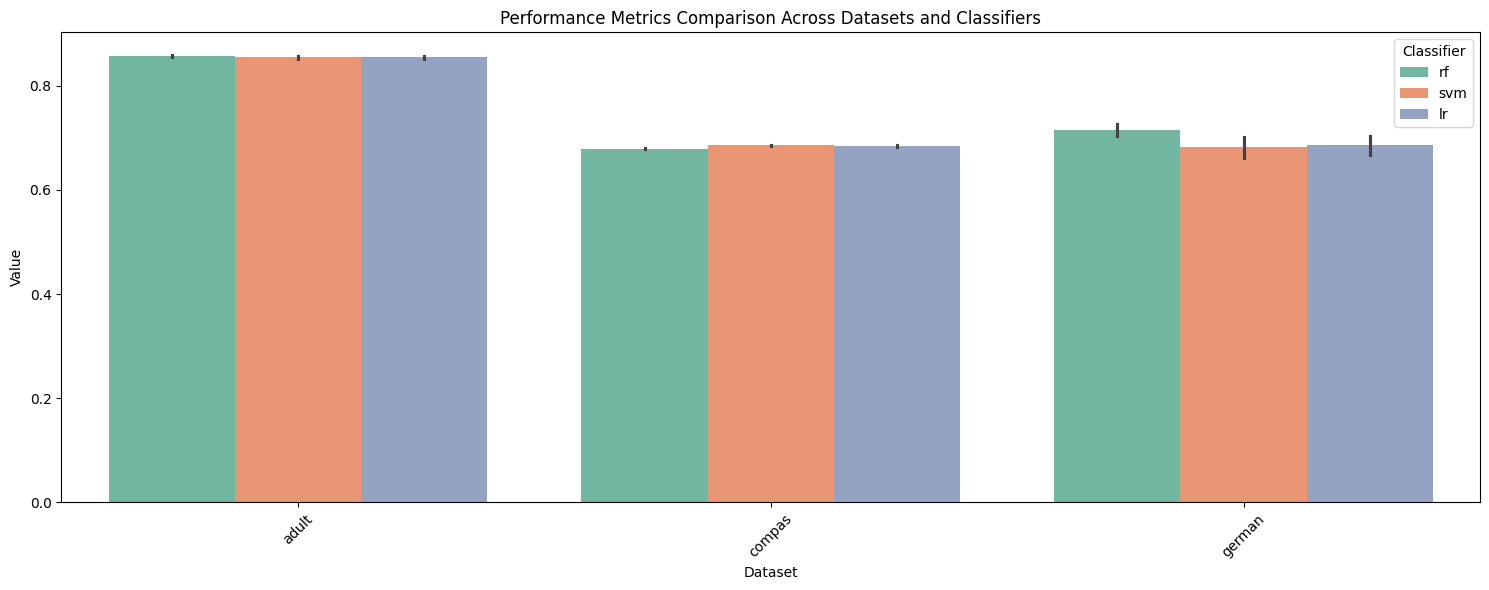

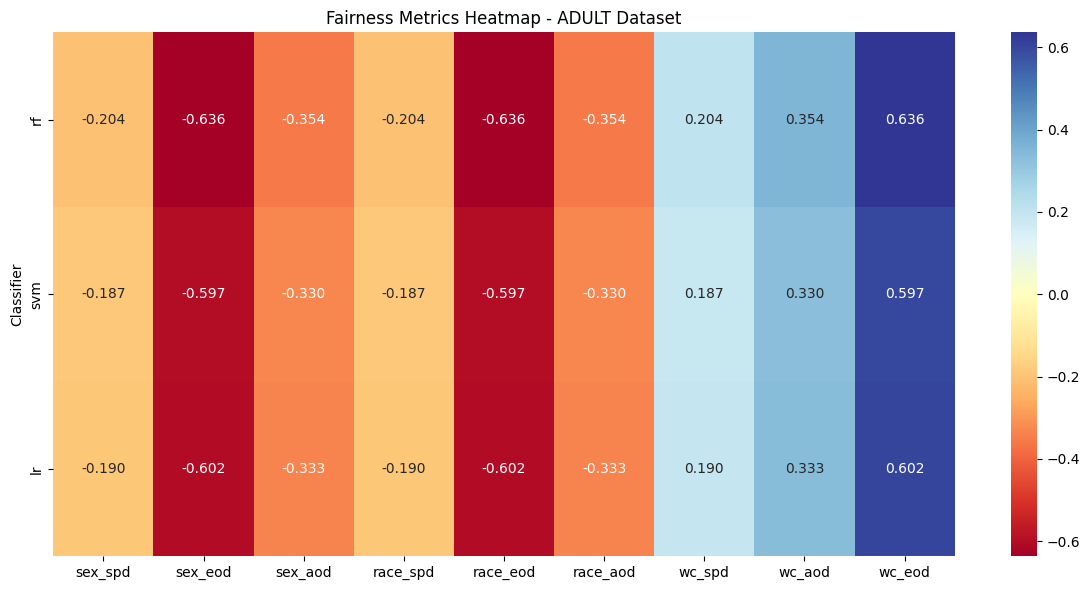

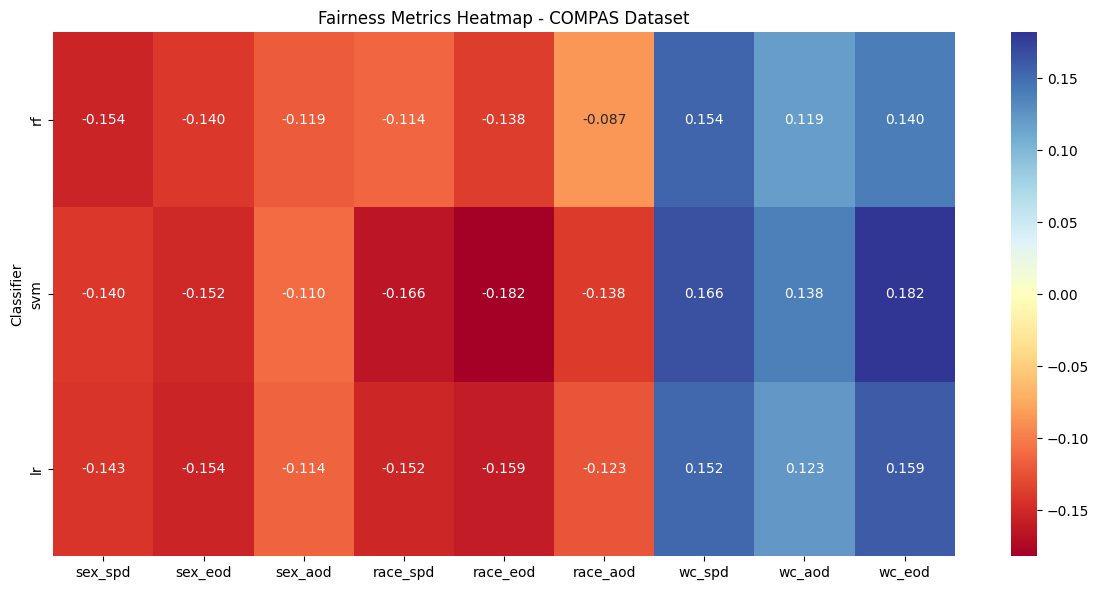

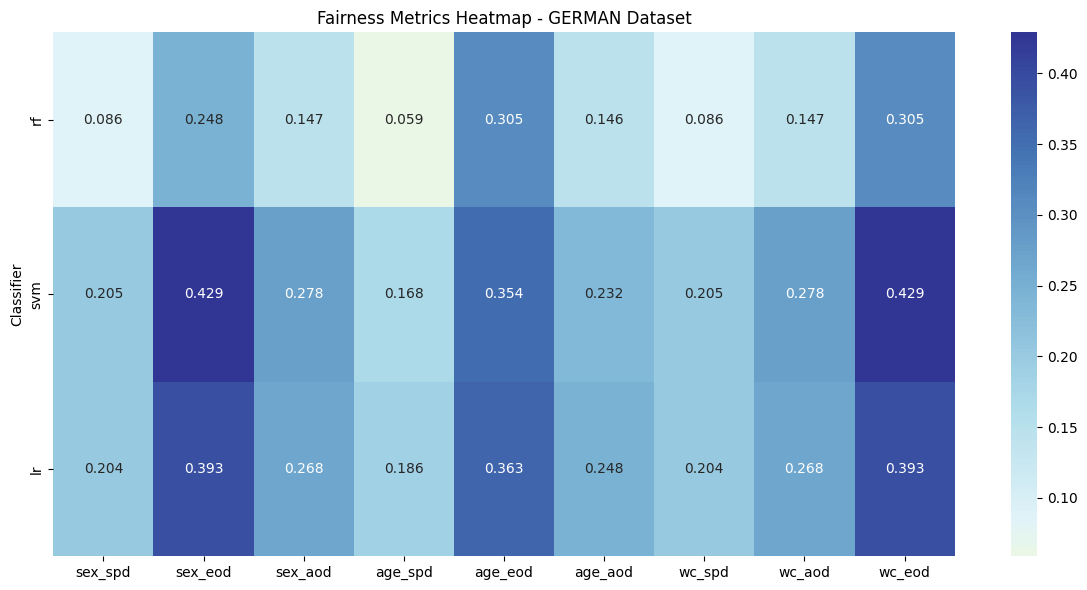

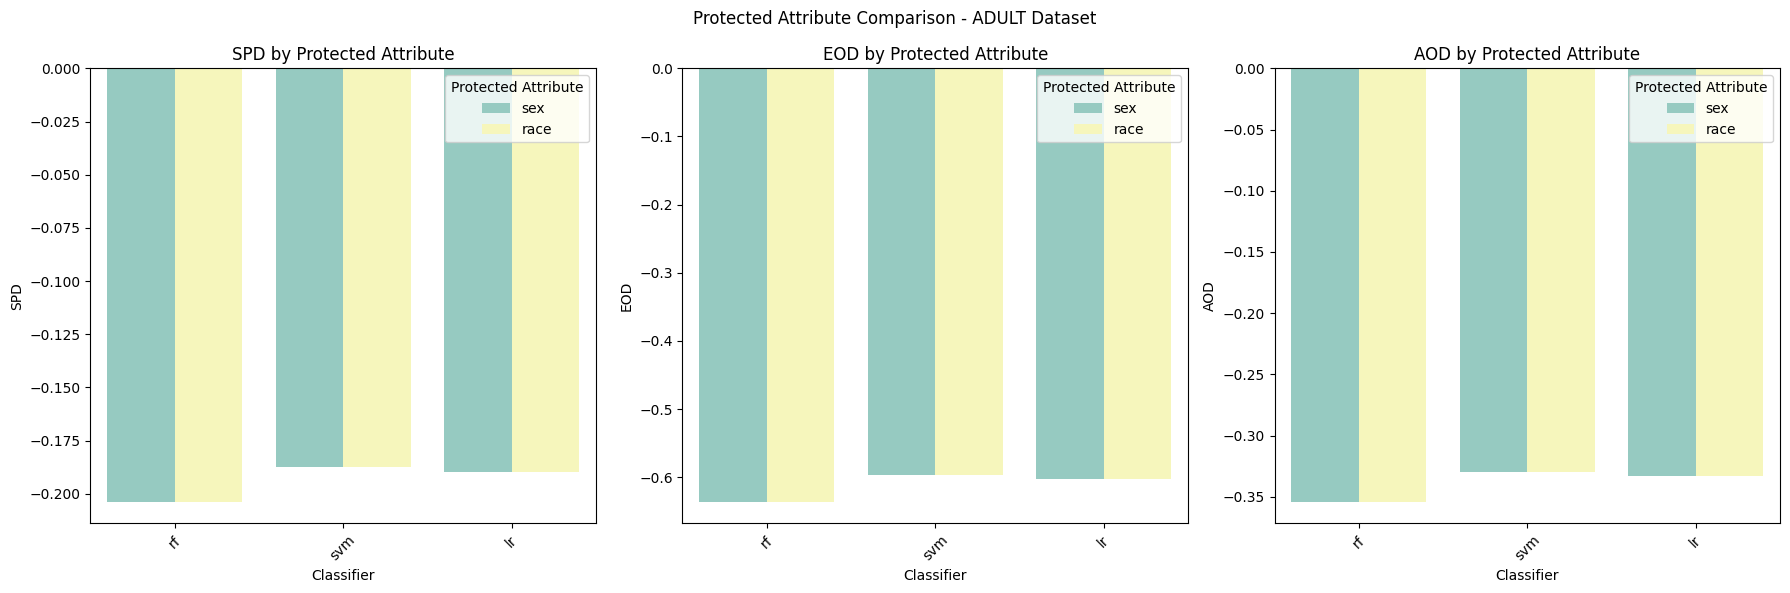

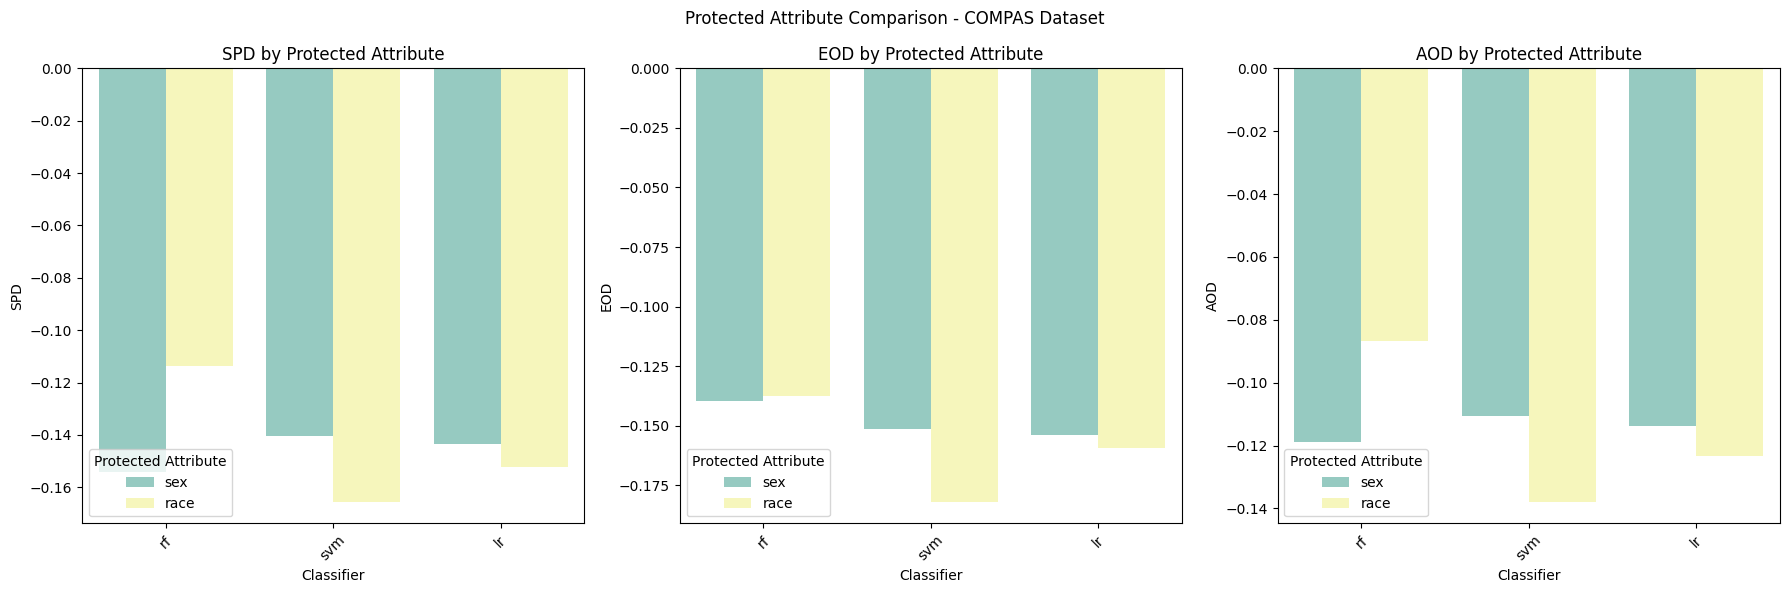

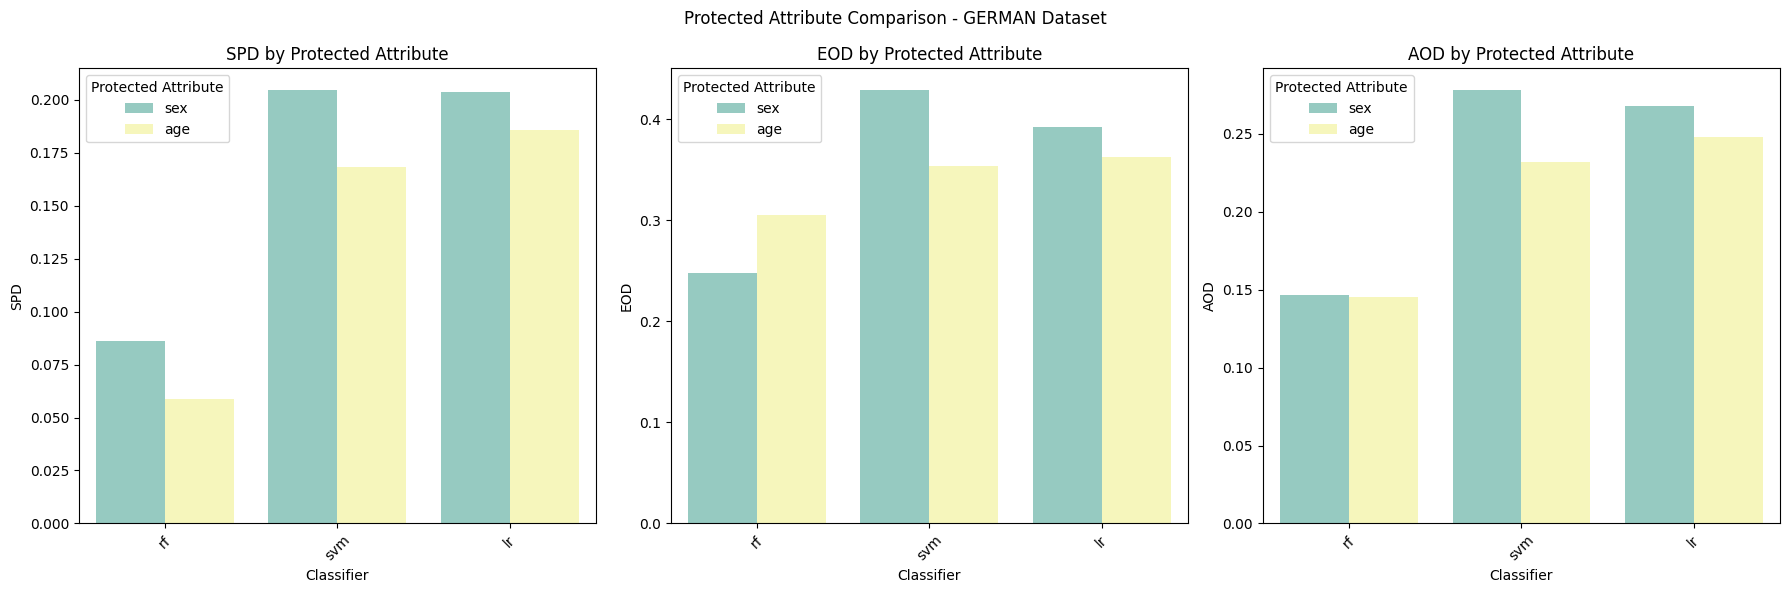

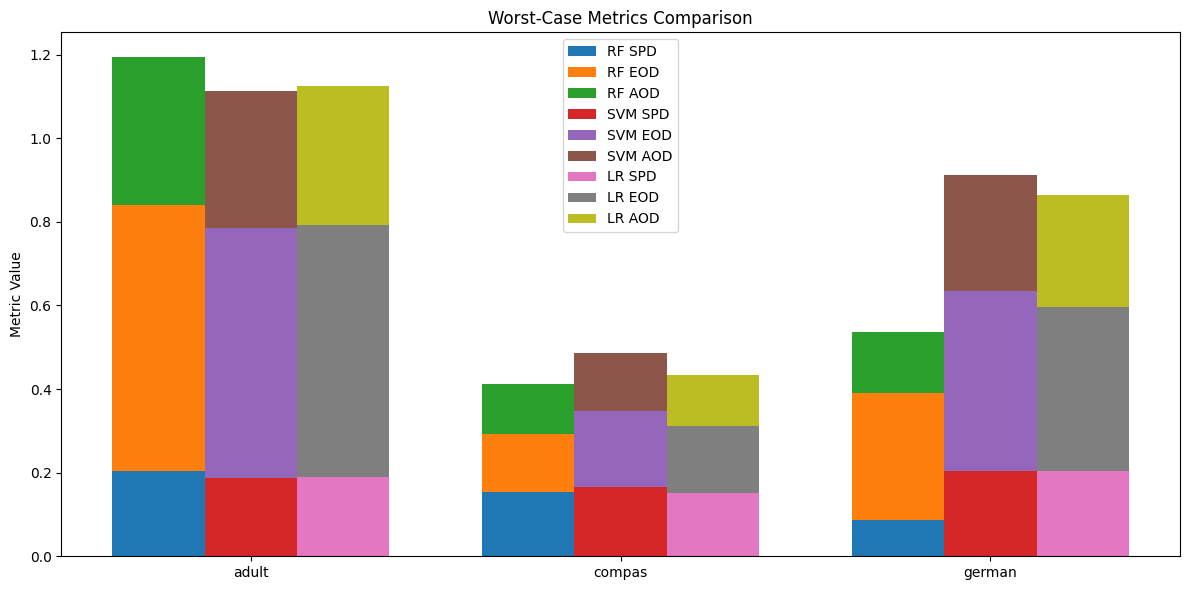


ADULT Dataset Summary:

Performance Metrics:
Classifier  accuracy  precision   recall       f1
        RF  0.859687   0.854804 0.859687 0.856264
       SVM  0.858050   0.851585 0.858050 0.852339
        LR  0.857981   0.851662 0.857981 0.852609

Fairness Metrics:
Classifier   sex_spd   sex_eod   sex_aod  race_spd  race_eod  race_aod   wc_spd   wc_aod   wc_eod
        RF -0.203781 -0.635965 -0.354081 -0.203781 -0.635965 -0.354081 0.203781 0.354081 0.635965
       SVM -0.187265 -0.597076 -0.329785 -0.187265 -0.597076 -0.329785 0.187265 0.329785 0.597076
        LR -0.189654 -0.602047 -0.333072 -0.189654 -0.602047 -0.333072 0.189654 0.333072 0.602047

COMPAS Dataset Summary:

Performance Metrics:
Classifier  accuracy  precision   recall       f1
        RF  0.678984   0.680110 0.678984 0.679425
       SVM  0.687298   0.685650 0.687298 0.683654
        LR  0.686374   0.685003 0.686374 0.681874

Fairness Metrics:
Classifier   sex_spd   sex_eod   sex_aod  race_spd  race_eod  race_aod   wc_s

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def create_performance_comparison(results):
    """Create performance metrics comparison plot."""
    # Prepare data for plotting
    plot_data = []
    for dataset in results.keys():
        for clf in results[dataset].keys():
            metrics = results[dataset][clf]['performance_metrics']
            for metric, value in metrics.items():
                plot_data.append({
                    'Dataset': dataset,
                    'Classifier': clf,
                    'Metric': metric,
                    'Value': value
                })
    
    df = pd.DataFrame(plot_data)
    
    # Create plot
    plt.figure(figsize=(15, 6))
    sns.barplot(x='Dataset', y='Value', hue='Classifier', data=df, palette='Set2')
    plt.title('Performance Metrics Comparison Across Datasets and Classifiers')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def create_fairness_heatmap(results):
    """Create heatmap for fairness metrics."""
    for dataset in results.keys():
        fairness_data = []
        for clf in results[dataset].keys():
            metrics = results[dataset][clf]['fairness_metrics']
            fairness_data.append({
                'Classifier': clf,
                **metrics
            })
        
        df = pd.DataFrame(fairness_data)
        df.set_index('Classifier', inplace=True)
        
        plt.figure(figsize=(12, 6))
        sns.heatmap(df, annot=True, cmap='RdYlBu', center=0, fmt='.3f')
        plt.title(f'Fairness Metrics Heatmap - {dataset.upper()} Dataset')
        plt.tight_layout()
        plt.show()

def create_protected_attr_comparison(results):
    """Create comparison plots for protected attributes."""
    for dataset in results.keys():
        protected_attrs = ['sex', 'race'] if dataset != 'german' else ['sex', 'age']
        
        metrics_data = []
        for clf in results[dataset].keys():
            metrics = results[dataset][clf]['fairness_metrics']
            for attr in protected_attrs:
                metrics_data.append({
                    'Classifier': clf,
                    'Protected Attribute': attr,
                    'SPD': metrics[f'{attr}_spd'],
                    'EOD': metrics[f'{attr}_eod'],
                    'AOD': metrics[f'{attr}_aod']
                })
        
        df = pd.DataFrame(metrics_data)
        
        # Create multi-metric plot
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        fig.suptitle(f'Protected Attribute Comparison - {dataset.upper()} Dataset')
        
        metrics = ['SPD', 'EOD', 'AOD']
        for i, metric in enumerate(metrics):
            sns.barplot(x='Classifier', y=metric, hue='Protected Attribute', 
                       data=df, ax=axes[i], palette='Set3')
            axes[i].set_title(f'{metric} by Protected Attribute')
            axes[i].tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()

def create_worst_case_comparison(results):
    """Create worst-case metrics comparison plot."""
    wc_data = []
    for dataset in results.keys():
        for clf in results[dataset].keys():
            metrics = results[dataset][clf]['fairness_metrics']
            wc_data.append({
                'Dataset': dataset,
                'Classifier': clf,
                'WC-SPD': metrics['wc_spd'],
                'WC-EOD': metrics['wc_eod'],
                'WC-AOD': metrics['wc_aod']
            })
    
    df = pd.DataFrame(wc_data)
    
    # Create plot
    fig, ax = plt.subplots(figsize=(12, 6))
    width = 0.25
    x = np.arange(len(df['Dataset'].unique()))
    
    for i, clf in enumerate(['rf', 'svm', 'lr']):
        clf_data = df[df['Classifier'] == clf]
        ax.bar(x + i*width, clf_data['WC-SPD'], width, label=f'{clf.upper()} SPD')
        ax.bar(x + i*width, clf_data['WC-EOD'], width, bottom=clf_data['WC-SPD'], 
               label=f'{clf.upper()} EOD')
        ax.bar(x + i*width, clf_data['WC-AOD'], width, 
               bottom=clf_data['WC-SPD'] + clf_data['WC-EOD'], 
               label=f'{clf.upper()} AOD')
    
    ax.set_ylabel('Metric Value')
    ax.set_title('Worst-Case Metrics Comparison')
    ax.set_xticks(x + width)
    ax.set_xticklabels(df['Dataset'].unique())
    ax.legend()
    plt.tight_layout()
    plt.show()

def create_summary_tables(results):
    """Create summary tables for all metrics."""
    summary_tables = {}
    
    for dataset in results.keys():
        # Performance metrics table
        perf_data = []
        for clf in results[dataset].keys():
            metrics = results[dataset][clf]['performance_metrics']
            perf_data.append({
                'Classifier': clf.upper(),
                **metrics
            })
        perf_df = pd.DataFrame(perf_data)
        
        # Fairness metrics table
        fair_data = []
        for clf in results[dataset].keys():
            metrics = results[dataset][clf]['fairness_metrics']
            fair_data.append({
                'Classifier': clf.upper(),
                **metrics
            })
        fair_df = pd.DataFrame(fair_data)
        
        summary_tables[dataset] = {
            'performance': perf_df,
            'fairness': fair_df
        }
    
    return summary_tables

def visualize_results(results):
    """Generate all visualizations and tables."""
    # Create performance comparison plot
    create_performance_comparison(results)
    
    # Create fairness heatmaps
    create_fairness_heatmap(results)
    
    # Create protected attribute comparison plots
    create_protected_attr_comparison(results)
    
    # Create worst-case comparison plot
    create_worst_case_comparison(results)
    
    # Create summary tables
    tables = create_summary_tables(results)
    
    # Display tables
    for dataset in tables.keys():
        print(f"\n{dataset.upper()} Dataset Summary:")
        print("\nPerformance Metrics:")
        print(tables[dataset]['performance'].to_string(index=False))
        print("\nFairness Metrics:")
        print(tables[dataset]['fairness'].to_string(index=False))

# Example usage:
visualize_results(results)